In [2]:
#S1 Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime as dt
import math

In [3]:
#S2 Downloading Market Data
print('Downloading Market data...')
start_date = '2010-01-01'
end_date = ''
nifty_data = yf.download('^NSEI', start = start_date, end = end_date)
print('Market data downloaded successfully.')

/tmp/ipython-input-3495266725.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download('^NSEI', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed

Market data downloaded successfully.


In [4]:
#S3 Cleaning the Data
print('Cleaning the data...')
print(f'Missing values in the dataset: {nifty_data.isnull().sum().sum()}')
nifty_data = nifty_data.sort_index()
nifty_close = nifty_data['Close'].values.reshape(-1,1)

Cleaning the data...
Missing values in the dataset: 0


In [5]:
#S4 Scaling the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(nifty_close)

In [6]:
#S5 Preprocessing the Data
print('Preprocessing the data...')
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:len(scaled_data)]

def create_dataset(dataset, time_step = 1):
    x, y = [], []
    for i in range(len(dataset) - time_step - 1):
        x.append(dataset[i:(i + time_step - 1)])
        y.append(dataset[i + time_step])
    return np.array(x), np.array(y)

#Create dataset with time steps
time_step = 60
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

Preprocessing the data...


In [7]:
#S6 Building LSTM Environment
model = Sequential()

#First LSTM layer with 50 neuron and return sequence = True to stack another LSTM layer
model.add(LSTM(units=50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

#Second LSTM layer with another 50 neuron
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

#Thirt LSTM layer with another 50 neuron
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

'''
#Fourth LSTM layer with another 50 neuron
model.add(LSTM(units=50))
model.add(Dropout(0.2))'''

# Output layer
model.add(Dense(units = 1))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
#S7 Training Setup
print('Training the model...')

# Using a batch size of 32 which is a good balance between computation speed and model accuracy
batch_size = 32
#epoch should be enough for the model to converge
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.1,
     callbacks = [early_stop],
    verbose = 1
)

# Make prediction and evaluate the model
print('Making Predictions...')
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test

# Calculate the performance metrics
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

Training the model...
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 7.0875e-04 - val_loss: 0.0028
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 7.1979e-04 - val_loss: 0.0012
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 6.0240e-04 - val_loss: 0.0023
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 5.4625e-04 - val_loss: 0.0021
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 5.0569e-04 - val_loss: 5.0184e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - loss: 5.2466e-04 - val_loss: 5.2010e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 4.6504e-04 - val_loss: 4.7843e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 4.6935e-04 - val_loss: 0.0011
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 4.3227e-04 - val_loss: 7.0232e-04
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step -


Training RMSE: 214.74
Testing RMSE: 726.49
Training MAE: 151.35
Testing MAE: 609.15
Training R2 Score: 1.00
Testing R2 Score: 0.93

Training Accuracy: 40.54%
Testing Accuracy: 14.45%
Visualising results...


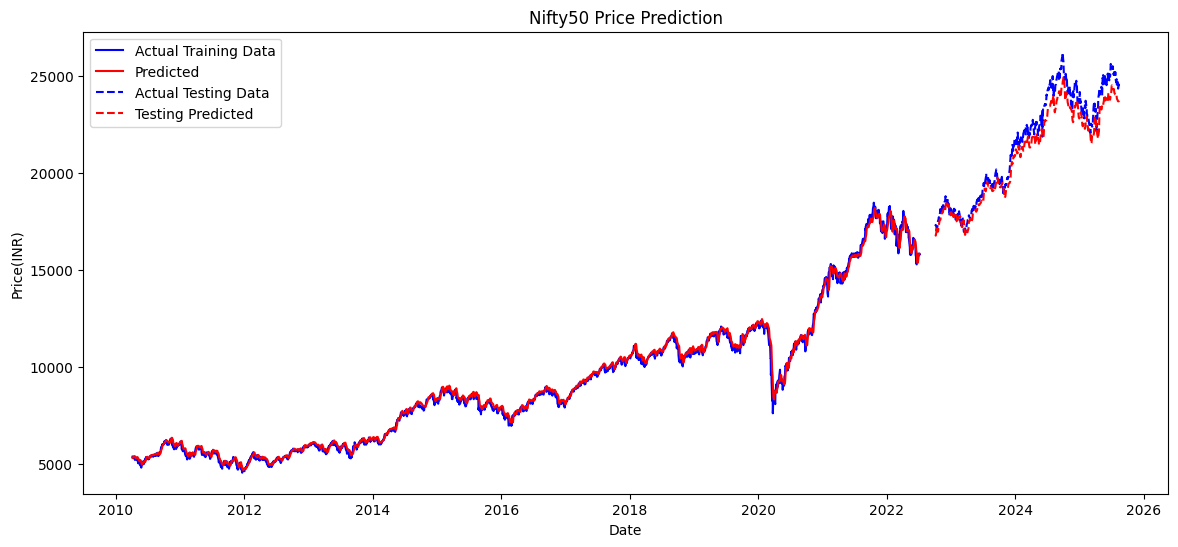

In [21]:
# S8 Data Visualisation
print(f"\nTraining RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

print(f"Training R2 Score: {train_r2:.2f}")
print(f"Testing R2 Score: {test_r2:.2f}")

# Calculate accuracy as a percentage (simplified for this context)
# In finance, begin within 1% of the actual value can be considered "accurate"
def calculate_accuracy(actual, predicted, threshold=0.01):
    within_threshold = np.abs(actual - predicted) <= threshold * actual
    accuracy = np.mean(within_threshold) * 100
    return accuracy

train_accuracy = calculate_accuracy(y_train_actual, train_predict)
test_accuracy = calculate_accuracy(y_test_actual, test_predict)

print(f"\nTraining Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

# Visualize the results
print("Visualising results...")
# Create a dataframe with actual and predicted values
train_dates = nifty_data.index[time_step+1 : train_size]
test_dates = nifty_data.index[train_size+time_step : -1]

plt.figure(figsize=(14, 6))
plt.plot(train_dates, y_train_actual, label='Actual Training Data', color='blue')
plt.plot(train_dates, train_predict, label='Predicted', color='red')
plt.plot(test_dates, y_test_actual, label='Actual Testing Data', color='blue', linestyle='--')
plt.plot(test_dates, test_predict, label='Testing Predicted', color='red', linestyle='--')
plt.title('Nifty50 Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price(INR)')
plt.legend()
plt.show()

Let's predict for the next 30 days
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━

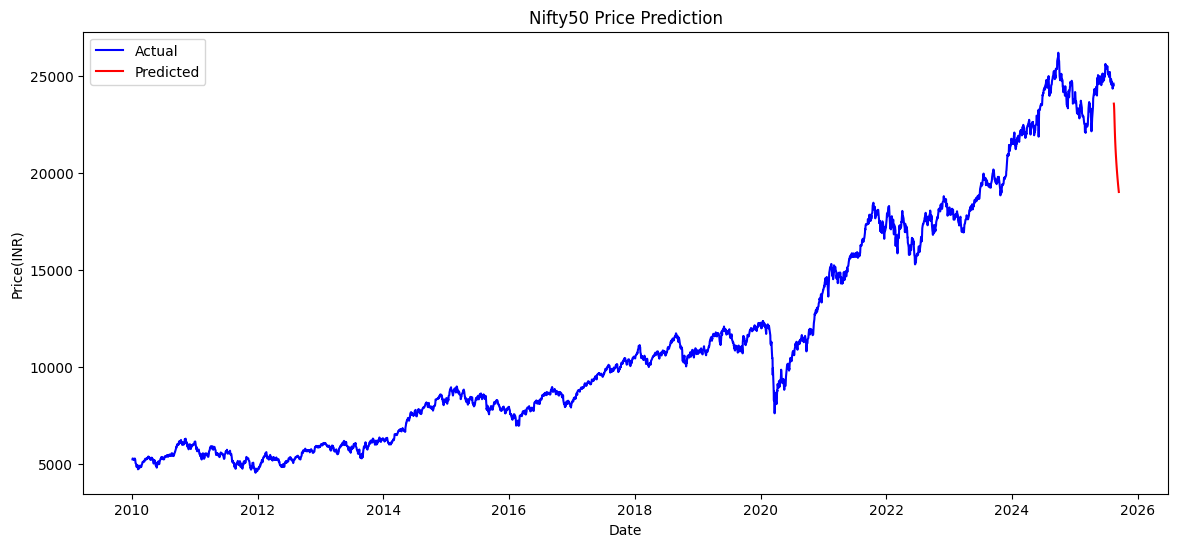

In [25]:
# S9 Future Forecasting
print("Let's predict for the next 30 days")
last_60_days = scaled_data[-60:]
future_predictions = []

for _ in range(30):
    x_future = last_60_days.reshape(1,time_step, 1)
    future_prediction = model.predict(x_future)

    last_60_days = np.append(last_60_days[1:], future_prediction)
    last_60_days = last_60_days.reshape(-1, 1)

    future_predictions.append(future_prediction[0][0])

# Inverse transform to get  actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_dates = nifty_data.index[-1]
future_dates = [last_dates + dt.timedelta(days=i+1) for i in range(1,31)]

# Visualize the future predictions
plt.figure(figsize=(14, 6))
plt.plot(nifty_data.index, nifty_close, label='Actual', color='blue')
plt.plot(nifty_data.index[-100:], nifty_close, label='Actual Data', color='blue')
plt.plot(future_dates, future_predictions, label='Predicted', color='red')
plt.title('Nifty50 Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price(INR)')
plt.legend()
plt.show()

In [26]:
print('\nModel Summery')
model.summary()


Model Summery


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)